In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import random
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import statistics
from collections import defaultdict
import time

from IPython.display import display
from IPython.display import clear_output

In [87]:
ALLELE_SEPARATOR = '|'
NUM_READ_FEATURES = 6
REF_DOWNSAMPLE = 5 # choose this many ref reads randomly
ARTIFACT_POPAF_THRESHOLD = 6 # only let things absent from gnomAD be artifacts out of caution
GERMLINE_POPAF_THRESHOLD = 1 #also very cautious.  There are so many germline variants we can be wasteful!
TLOD_THRESHOLD = 5 # we are classified artifacts other than sequencing errors described by base qualities

NON_ARTIFACT_PER_ARTIFACT = 10

def process_and_pickle_from_file(raw_file, pickled_file):
    # we don't want to read in the whole file at once.  Too much memory!
    #data = pd.read_table(raw_file)
    
    # calculate the average
    sum_of_reads = np.zeros(NUM_READ_FEATURES)
    sum_of_squared_reads = np.zeros(NUM_READ_FEATURES)
    num_reads = 0

    #list of tuples (ref_tensor, alt_tensor)
    parsed_data = []
    
    artifact_counts = [0] * 500
    
    too_few_ref = 0
    
    # simple online method for balanced data set where for each k-alt-read artifact there are 
    # NON_ARTIFACT_PER_ARTIFACT (downsampled) k-alt-read non-artifacts.  That is, alt count is not an informative feature.
    unmatched_artifact_counts = []
    
    with open(raw_file) as fp: 
        fp.readline() #skip header
        
        
        for n, line in enumerate(fp):
            if n % 10000 == 0:
                clear_output(wait=True)
                print("Processing line " + str(n))
                
            tokens = line.split()
            position = tokens[0] + ":" + tokens[1]
            ref = tokens[2]
            alt = tokens[3]
            germq = tokens[4]
            popaf = float(tokens[5])
            tlod = float(tokens[6])
            nalod = float(tokens[7])
            normal = tokens[8]
            tumor = tokens[9]
            
            # TODO: put in a TLOD threshold so that we distinguish true artifacts from plain old
            # TODO: sequencing error
            
            # don't bother processing tensors if popaf out of range
            if popaf < ARTIFACT_POPAF_THRESHOLD and popaf > GERMLINE_POPAF_THRESHOLD:
                continue
            elif tlod < TLOD_THRESHOLD:
                continue

            #we're not worried about true somatic variants getting counted as artifacts
            # because DREAM 1 is pure, monoclonal and has high AF
            allele_strings = tumor.split(ALLELE_SEPARATOR)
            ref_tensor = np.fromstring(allele_strings[0], dtype=int, sep=',').reshape((-1, NUM_READ_FEATURES))
            alt_tensor = np.fromstring(allele_strings[1], dtype=int, sep=',').reshape((-1,NUM_READ_FEATURES))
            
            if len(alt_tensor) == 0:
                continue
            
            # this is very hacky and unprinciple but it will do for now
            if len(ref_tensor) < REF_DOWNSAMPLE:
                too_few_ref += 1
                continue
            
            is_artifact = False
            
            alt_count = len(alt_tensor)
            ref_count = len(ref_tensor)
            af = 0 if alt_count == 0 else alt_count / (alt_count + ref_count)
            
            #downsample the ref reads
            ref_tensor = ref_tensor[np.random.choice(len(ref_tensor), REF_DOWNSAMPLE, replace=False)]
            
            if af < 0.2 and popaf >= ARTIFACT_POPAF_THRESHOLD: #primitive calling of artifact vs germline het!!
                artifact_counts[alt_count] = artifact_counts[alt_count] + 1
                unmatched_artifact_counts.extend([alt_count]*NON_ARTIFACT_PER_ARTIFACT)
                is_artifact = True
            elif af > 0.35 and popaf < GERMLINE_POPAF_THRESHOLD and unmatched_artifact_counts:
                downsample_count = min(alt_count, unmatched_artifact_counts.pop())
                alt_tensor = alt_tensor[np.random.choice(len(alt_tensor), downsample_count, replace=False)]
            else:
                continue

            num_reads += len(ref_tensor) + len(alt_tensor)
            sum_of_reads = sum_of_reads + np.sum(ref_tensor, axis=0) + np.sum(alt_tensor, axis=0)
            sum_of_squared_reads = sum_of_squared_reads + np.sum(ref_tensor**2, axis=0) + np.sum(alt_tensor**2, axis=0)

            parsed_data.append((ref_tensor, alt_tensor, is_artifact))

    mean = sum_of_reads / num_reads
    stdev = np.sqrt(sum_of_squared_reads / num_reads - mean**2)

    normalized_data = []
    for ref, alt, is_artifact in parsed_data:
        normalized_data.append(((ref - mean) / stdev, (alt - mean) / stdev, is_artifact))
        
    with open(pickled_file, 'wb') as f:
        pickle.dump(normalized_data, f)
        
    print(too_few_ref)

In [88]:
raw_file = '/Users/davidben/Desktop/m3-testing/snps.table'
pickled_file = '/Users/davidben/Desktop/m3-testing/snps.pickle'
process_and_pickle_from_file(raw_file, pickled_file)

Processing line 3930000
1443859


In [89]:
class Mutect3Dataset(Dataset):
    
    def __init__(self, pickled_file):
        with open(pickled_file, 'rb') as f:
            self.data = pickle.load(f)
            random.shuffle(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        (ref_set, alt_set, is_artifact) = self.data[index]
                
        label = 1 if is_artifact else 0
            
        return torch.from_numpy(ref_set).float(), torch.from_numpy(alt_set).float(), label

In [90]:
dataset = Mutect3Dataset(pickled_file)
train_len = int(0.9*len(dataset))
valid_len = len(dataset) - train_len
train, valid = random_split(dataset, lengths=[train_len, valid_len])

In [139]:
artifact_alt_counts = np.array([len(datum[1]) for datum in dataset if datum[2] == 1] )
non_artifact_alt_counts = np.array([len(datum[1]) for datum in dataset if datum[2] == 0] )
print((np.bincount(non_artifact_alt_counts)[0:20]/NON_ARTIFACT_PER_ARTIFACT).tolist())
print((np.bincount(artifact_alt_counts)[0:20]).tolist())

[0.0, 196.0, 1300.0, 1397.8, 1462.7, 1151.3, 1027.5, 843.1, 752.0, 592.2, 596.7, 482.9, 362.7, 280.1, 224.7, 185.4, 157.7, 123.0, 98.6, 71.3]
[0, 196, 1300, 1395, 1452, 1138, 1015, 830, 740, 584, 589, 481, 357, 278, 229, 188, 161, 124, 97, 70]


In [133]:
class LinearStack(nn.Module):
    #layer_sizes starts from the input and ends with the output
    #optional batch normalization
    def __init__(self, layer_sizes, batch_normalize=False):
        
        super(LinearStack, self).__init__()
        
        self.layers = nn.ModuleList()
        for k in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[k], layer_sizes[k+1]))
            
        self.bn = nn.ModuleList()
        if batch_normalize:  
            #batch normalize after every linear transformation
            for size in layer_sizes[1:]:
                self.bn.append(nn.BatchNorm1d(num_features=size))
            
    def forward(self, x):

        # Feedforward -- note that last layer has no non-linearity
        for n, layer in enumerate(self.layers):
            x = layer(x)
            if self.bn:
                x = self.bn[n](x)
            if n < len(self.layers) - 1:
                x = nn.functional.relu(x)

        return x

In [183]:
class ReadSetClassifier(nn.Module):
    #embedding layer sizes include input, aggregation hidden layer sizes do not include its input which is 
    # the embedding output, not its output which is a binary classification
    def __init__(self, embedding_layer_sizes, aggregation_hidden_layer_sizes):
        super(ReadSetClassifier, self).__init__()
        
        # phi is the universal read embedding function
        self.phi = LinearStack(embedding_layer_sizes, batch_normalize=False)
        self.embedding_dimension = embedding_layer_sizes[-1]
        
        # rho is the universal aggregation function
        #the +1 is for the split of the sum of embeddings into the mean and the number of alt (but not ref) reads
        # the *2 is for the use of both ref and alt reads
        self.rho = LinearStack([2*self.embedding_dimension + 1] + aggregation_hidden_layer_sizes, batch_normalize=False)
        
        # the scalar anomaly score function
        self.log_score = nn.Linear(aggregation_hidden_layer_sizes[-1], 1)
        
        # convert a score to a linear (pre-sigmoid-application for the sake o BCE loss) artifact probability
        # this is just a simple linear function equivalent to setting a decision boundary and a width
        self.artifact_probability = nn.Linear(1, 1)
        
    # see the custom collate_fn for information on the batched input
    def forward(self, ref_reads, alt_reads, ref_counts, alt_counts):
    
        # broadcast the embedding to each read
        num_sets = len(ref_counts)
        
        phi_ref = torch.sigmoid(self.phi(ref_reads))
        phi_alt = torch.sigmoid(self.phi(alt_reads))
                        
        ref_end = torch.cumsum(ref_counts, dim=0).numpy()
        ref_slices = [slice(0 if n == 0 else ref_end[n-1],ref_end[n]) for n in range(num_sets)]
        alt_end = torch.cumsum(alt_counts, dim=0).numpy()
        alt_slices = [slice(0 if n == 0 else alt_end[n-1],alt_end[n]) for n in range(num_sets)]
                
        # note that after taking means, tensors are now num_sets x embedding dimension
        ref_means = torch.cat([torch.mean(phi_ref[slice], dim=0, keepdim=True) for slice in ref_slices], dim=0)
        alt_means = torch.cat([torch.mean(phi_alt[slice], dim=0, keepdim=True) for slice in alt_slices], dim=0)
        
        
        #now we'll stack the ref and alt means side-by-side along with counts so that each row of the resulting
        # 2D tensor is (mean ref 1, . . . mean ref D, mean alt 1, . . . mean alt D, ref count, alt count)
        stacked_embeddings = torch.cat((ref_means, alt_means, torch.unsqueeze(alt_counts,1)), dim=1)
                
        # broadcast the aggregation over the batch, then broadcast the DevNet anomaly score,
        log_scores = self.log_score(self.rho(stacked_embeddings))
        scores = torch.exp(log_scores)
        output = self.artifact_probability(scores)
        
        # note that no non-linearity is applied here because nn.BCEWithLogitsLoss() includes
        # the sigmoid.  Thus when classifying we will have to apply the sigmoid explicitly
        # note also that we return the scores in order to pass it to a custom loss function
        return torch.squeeze(output), torch.squeeze(scores)

In [94]:
def binary_acc(y_pred, y_test):
    booleans = torch.sign(y_pred) == torch.sign(y_test - 0.5)
    return booleans.float().mean()

In [111]:
# because our read sets have different sizes, we can't just form a batch by naively stacking tensors
# thus we need a custom collate function for our data loader (and we will have to be aware of the custom format the
# data loader provides for training)

# input batch is a list of tuples ref_reads (2D tensor, one row per read), alt_reads (same), label (scalar)
# collated batch contains:
# ref (alt) reads: 2D tensors of ALL ref (alt) reads, not separated by set.
# ref (alt) counts: number of reads in ref (alt) read sets, in same order as read tensors
# labels: 1D tensor of 0 if non-artifact, 1 if artifact
# Example: if we have two input data, one with alt reads [[0,1,2], [3,4,5] and the other with 
# alt reads [[6,7,8], [9,10,11], [12,13,14] then the output alt reads tensor is
# [[0,1,2], [3,4,5], [6,7,8], [9,10,11], [12,13,14]] and the output counts are [2,3]
# inside the model, the counts will be used to separate the reads into sets
def collate_read_sets(batch):
    ref_counts = torch.IntTensor([len(item[0]) for item in batch])
    alt_counts = torch.IntTensor([len(item[1]) for item in batch])
    ref = torch.cat([item[0] for item in batch], dim=0)
    alt = torch.cat([item[1] for item in batch], dim=0)
    labels = torch.FloatTensor([item[2] for item in batch])
    return ref, alt, ref_counts, alt_counts, labels

In [96]:
def round_alt_count_for_binning(alt_count):
    if alt_count < 10:
        return alt_count
    elif alt_count < 20:
        return alt_count - alt_count % 2
    else:
        return alt_count - alt_count % 5

In [189]:
# penalize artifact scores of non-artifacts for being large
# this helps us achieve one-class classification, the ability to recognize artifacts as anomalous 
# even with few training examples by virtue of them not fitting the pattern of non-artifacts.  Such a scheme only
# works when the score (or representation) of non-anomalies is forced into a compact space
# inputs are 1-D tensors -- a batch of scores and a batch of labels, 0 for non-artifact, 1 for artifact
# we only regularize non-artifacts
def artifact_score_regularizer(scores, labels):
    return torch.sum(nn.functional.relu(scores - 1)*(1.0 - labels))

In [206]:
BATCH_SIZE = 64

train_labels = [datum[2] for datum in train]
valid_labels = [datum[2] for datum in valid]

model = ReadSetClassifier([NUM_READ_FEATURES, 20, 10], [10, 10, 5]).float()
class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
samples_per_epoch = 20*int(class_counts[1]) #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact

class_weights = 1.0/class_counts
train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
valid_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[valid_labels], num_samples = int(samples_per_epoch/10))
    
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_read_sets, drop_last=True)
valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, sampler=valid_sampler, collate_fn=collate_read_sets, drop_last=True)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# track loss and accuracy as map from alt count bins to lists by epoch
train_losses = []
valid_losses = []

# these are only for the last epoch
valid_accs_lists = defaultdict(list)
valid_accs = {}
artifact_scores = defaultdict(list)
non_artifact_scores = defaultdict(list)

EPOCHS = 100
for epoch in range(0, EPOCHS):
    for is_training in [True, False]:        
        model.train(is_training)
        epoch_loss = 0

        # note the custom collate_fn above: ref_reads and alt_reads 2D tensors of all reads, one read per row, 
        # labels is a 1D tensor, ref_counts and alt_counts are lists
        loader = train_loader if is_training else valid_loader
        for batch, (ref_reads, alt_reads, ref_counts, alt_counts, labels) in enumerate(loader): 
            if batch % 100 == 0:
                clear_output(wait=True)
                print(("Training " if is_training else "Validating ") + "epoch " + str(epoch + 1) + ", batch: " + str(batch) + ", sample: " + str(batch * BATCH_SIZE))
            
            predictions, scores = model(ref_reads, alt_reads, ref_counts, alt_counts)              
            loss = criterion(predictions, labels) #+ 0.00*artifact_score_regularizer(scores, labels)
            epoch_loss += loss.item()
          
            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            elif epoch == EPOCHS - 1:  # record validation accuracy on last epoch
                batch_size = len(alt_counts)
                
                for n in range(batch_size):                
                    alt_count_bin = round_alt_count_for_binning(alt_counts[n].item())
                    valid_accs_lists[alt_count_bin].append(binary_acc(predictions[n], labels[n]).item())
                    
                    score = scores[n].item()
                    (artifact_scores if labels[n] == 1 else non_artifact_scores)[alt_count_bin].append(score)
            
        # end of epoch
        (train_losses if is_training else valid_losses).append(epoch_loss / (len(loader)*BATCH_SIZE))
# model is trained

for alt_count_bin, accs in valid_accs_lists.items():
    valid_accs[alt_count_bin]= statistics.mean(accs)

Validating epoch 100, batch: 300, sample: 19200


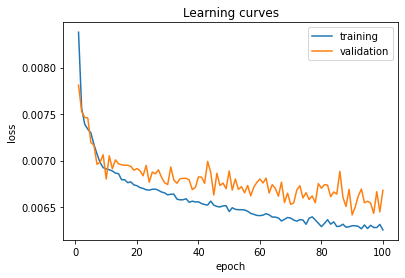

In [207]:
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_losses, label = "training")
plt.plot(epochs, valid_losses, label = "validation")
plt.title("Learning curves")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

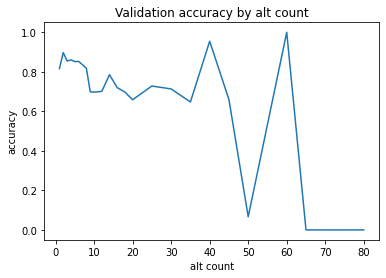

In [208]:
counts = sorted(valid_accs.keys())
accs = [valid_accs[count] for count in counts]
plt.plot(counts, accs)
plt.title("Validation accuracy by alt count")
plt.xlabel("alt count")
plt.ylabel("accuracy")
plt.show()

<ipython-input-209-031e76bd11f3>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


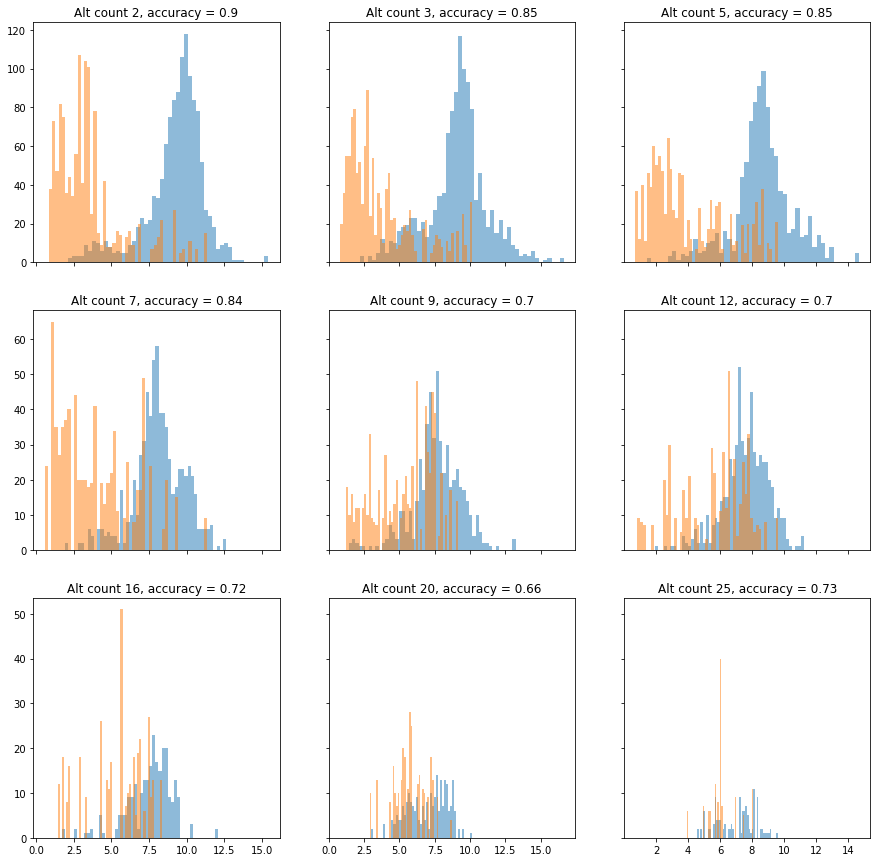

In [209]:
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
fig.set_figheight(15)
fig.set_figwidth(15)
for n, count in enumerate([2, 3, 5, 7, 9, 12, 16, 20, 25]):
    row = int(n/3)
    col = n % 3
    ax[row, col].hist(non_artifact_scores[count], bins=50, alpha = 0.5, label = 'non-artifacts')
    ax[row, col].hist(artifact_scores[count], bins=50, alpha = 0.5, label = 'artifacts')
    ax[row, col].set_title("Alt count " + str(count) + ", accuracy = " + str(round(valid_accs[count],2)))
    #ax[row, col].xlabel("score")
fig.show()
    

In [178]:
non_artifact_scores[4]

[-0.023066729307174683,
 -0.023948222398757935,
 -0.018196165561676025,
 -0.018596380949020386,
 -0.022491902112960815,
 -0.021379441022872925,
 -0.02281329035758972,
 0.027008801698684692,
 -0.019431233406066895,
 -0.013514399528503418,
 -0.02141597867012024,
 -0.020508259534835815,
 -0.022611647844314575,
 -0.01966184377670288,
 -0.01726585626602173,
 -0.021824896335601807,
 -0.020055800676345825,
 -0.027949988842010498,
 -0.017962902784347534,
 -0.022460609674453735,
 0.005942434072494507,
 -0.020927846431732178,
 -0.00765874981880188,
 -0.027104288339614868,
 -0.022910237312316895,
 -0.022985756397247314,
 0.06955888867378235,
 0.026510804891586304,
 -0.022785216569900513,
 -0.016471028327941895,
 -0.021094053983688354,
 -0.0217762291431427,
 -0.02141597867012024,
 -0.024183034896850586,
 -0.005700021982192993,
 0.04270511865615845,
 -0.019107133150100708,
 0.049094319343566895,
 -0.021584779024124146,
 -0.0217762291431427,
 -0.004047513008117676,
 -0.02610558271408081,
 -0.0240258

In [36]:
class_counts

tensor([203587.,  20390.])

In [86]:
float(-2.646e-01)

-0.2646

In [121]:
c=[1,2,3]
c[1:]

[2, 3]